In [1]:
import networkx as nx
import random
import matplotlib.pyplot as plt
import numpy as np
import bisect
from typing import List, Tuple, Optional



In [2]:
courses = [
    ("Intro to Programming", []),
    ("Data Structures", ["Intro to Programming"]),
    ("Algorithms", ["Data Structures"]),
    ("Intro to AI", ["Data Structures"]),
    ("Machine Learning", ["Intro to AI"]),
    ("Deep Learning", ["Machine Learning"]),
    ("Intro to Security", ["Intro to Programming"]),
    ("Network Security", ["Intro to Security"]),
    ("Cryptography", ["Intro to Security"]),
    ("Intro to Data Science", ["Intro to Programming"]),
    ("Data Mining", ["Intro to Data Science"]),
    ("Big Data", ["Data Mining"]),
    ("Databases", ["Data Structures"]),
    ("Operating Systems", ["Data Structures"]),
    ("Software Engineering", ["Intro to Programming"]),
    ("Computer Networks", ["Intro to Programming"]),
    ("Web Development", ["Intro to Programming"]),
    ("Statistics", ["Intro to Programming"]),
    ("Linear Algebra", []),
    ("Discrete Math", [])
]

interest_sequences = {
    "AI": ["Intro to Programming", "Data Structures", "Intro to AI", "Machine Learning", "Deep Learning"],
    "Security": ["Intro to Programming", "Intro to Security", "Network Security", "Cryptography"],
    "Data Science": ["Intro to Programming", "Intro to Data Science", "Data Mining", "Big Data"]
}

In [3]:
G = nx.DiGraph()
for course, prereqs in courses:
    G.add_node(course)
    for prereq in prereqs:
        G.add_edge(prereq, course)


In [4]:
def can_take_course(course, completed_courses):
    prereqs = list(G.predecessors(course)) if course in G.nodes else []
    return all(prereq in completed_courses for prereq in prereqs)

# Simulate a student's completed courses
def generate_completed_courses():
    completed = set()
    available = [course for course, prereqs in courses if not prereqs]
    num_courses = random.randint(1, 10)  # Random progress
    for _ in range(num_courses):
        if not available:
            break
        course = random.choice(available)
        completed.add(course)
        available.remove(course)
        # Add courses that now have their prerequisites satisfied
        for next_course in G.successors(course):
            if can_take_course(next_course, completed):
                available.append(next_course)
    return completed

In [ ]:
def calculate_gpa(grades: List[float], grade_scale: Optional[List[Tuple[float, float]]]=None) -> float:
    default_scale = [
        (0,  0.0),   
        (60, 1.0),   
        (63, 1.3),   
        (67, 1.7),   
        (70, 2.0),   
        (73, 2.3),   
        (77, 2.7),   
        (80, 3.0),   
        (83, 3.3),   
        (87, 3.7),   
        (90, 4.0),   
        (93, 4.0)    
    ]
    grade_scale =  default_scale
    if not grades:
        return 0.0
    for grade in grades:
        if not 0 <= grade <= 100:
            raise ValueError(f"Grade {grade} is outside valid range [0, 100]")
    thresholds = [threshold for threshold, _ in grade_scale]
    grade_points = []
    for grade in grades:
        index = bisect.bisect_right(thresholds, grade) - 1
        grade_points.append(grade_scale[index][1])
        
    return round(sum(grade_points) / len(grade_points), 2) if grade_points else 0.0

In [ ]:
def generate_student(student_id):
    interests = random.sample(list(interest_sequences.keys()), k=random.randint(1, 3))
    completed_courses = generate_completed_courses()
    grades = {course: random.randint(40, 100) for course in completed_courses}
    passed_courses = {course for course, grade in grades.items() if grade >= 60}
    gpa = calculate_gpa(list(grades.values()))  
    return {
        "id": student_id,
        "interests": interests,
        "completed_courses": completed_courses,
        "passed_courses": passed_courses,
        "grades": grades,
        "gpa": gpa
    }
students = [generate_student(i) for i in range(1, 101)]


In [ ]:
class CourseRecommender:
    def __init__(self, courses, interest_sequences, graph):
        self.courses = {course: idx for idx, (course, _) in enumerate(courses)}
        self.interest_sequences = interest_sequences
        self.graph = graph
        self.state_space = {}
        self.state_count = 0
        self.action_space = list(self.courses.keys())
        self.q_table = None

    def get_state(self, student):
        passed = student["passed_courses"]
        failed = {c for c, g in student["grades"].items() if g < 60}
        interests = student["interests"]
        num_completed = sum(1 for interest in interests for course in interest_sequences[interest] if course in passed)
        num_failed_prereqs = sum(1 for interest in interests for course in interest_sequences[interest] if course in failed)
        gpa_bucket = int(min(student["gpa"], 4.0))  
        term = min(len(student["completed_courses"]) // 4, 5)
        state = (num_completed, num_failed_prereqs, gpa_bucket, term)
        if state not in self.state_space:
            self.state_space[state] = self.state_count
            self.state_count += 1
        return self.state_space[state]

    def get_eligible_actions(self, student):
        passed = student["passed_courses"]
        failed = {c for c, g in student["grades"].items() if g < 60}
        eligible = []
        for course in failed:
            if any(course in self.interest_sequences[interest] for interest in student["interests"]):
                eligible.append(course)
        for course in self.action_space:
            if course not in student["completed_courses"] and can_take_course(course, passed):
                eligible.append(course)
        return eligible

    def initialize_q_table(self):
        self.q_table = np.zeros((self.state_count, len(self.action_space)))

    def compute_reward(self, student, action):
        interests = student["interests"]
        failed = {c for c, g in student["grades"].items() if g < 60}
        retake_reward = 3 if action in failed and any(action in self.interest_sequences[interest] for interest in interests) else 0
        interest_reward = 2 if any(action in self.interest_sequences[interest] for interest in interests) else 0.5
        simulated_grade = min(100, random.gauss(student["gpa"] * 25, 10))
        gpa_boost = (calculate_gpa([simulated_grade]) - 1.0) if simulated_grade >= 60 else -1
        return retake_reward + interest_reward + gpa_boost

    def train(self, students, episodes=1000, alpha=0.1, gamma=0.9, epsilon=0.1):
        self.initialize_q_table()
        for _ in range(episodes):
            student = random.choice(students)
            state = self.get_state(student)
            eligible_actions = self.get_eligible_actions(student)
            if not eligible_actions:
                continue
            if random.random() < epsilon:
                action = random.choice(eligible_actions)
            else:
                action_idx = np.argmax([self.q_table[state, self.action_space.index(action)] for action in eligible_actions])
                action = eligible_actions[action_idx]
            reward = self.compute_reward(student, action)
            next_state = state  
            action_idx = self.action_space.index(action)
            self.q_table[state, action_idx] += alpha * (reward + gamma * np.max(self.q_table[next_state]) - self.q_table[state, action_idx])

    def recommend_courses(self, student, max_courses=4):
        state = self.get_state(student)
        eligible_actions = self.get_eligible_actions(student)
        if not eligible_actions:
            return []
        scores = [(action, self.q_table[state, self.action_space.index(action)]) for action in eligible_actions]
        scores.sort(key=lambda x: x[1], reverse=True)
        return [action for action, _ in scores[:max_courses]]


In [ ]:
recommender = CourseRecommender(courses, interest_sequences, G)
for student in students:
    recommender.get_state(student)
recommender.train(students, episodes=1000)

In [13]:
for student in students:
    student["recommendations"] = recommender.recommend_courses(student)

print("Adjusted RL-Based Recommendations for 3 Students:")
for student in students[:3]:
    print(f"\nStudent {student['id']}:")
    print(f"Interests: {student['interests']}")
    print(f"Completed Courses: {student['completed_courses']}")
    print(f"Grades (0-100): {student['grades']}")
    print(f"GPA: {student['gpa']}")
    print(f"Recommended Courses: {student['recommendations']}")

Adjusted RL-Based Recommendations for 3 Students:

Student 1:
Interests: ['AI', 'Security', 'Data Science']
Completed Courses: {'Discrete Math', 'Linear Algebra', 'Data Structures', 'Intro to Programming'}
Grades (0-100): {'Discrete Math': 100, 'Linear Algebra': 90, 'Data Structures': 62, 'Intro to Programming': 79}
GPA: 2.92
Recommended Courses: ['Intro to AI', 'Algorithms', 'Intro to Security', 'Intro to Data Science']

Student 2:
Interests: ['Security', 'Data Science']
Completed Courses: {'Discrete Math', 'Cryptography', 'Linear Algebra', 'Computer Networks', 'Intro to Data Science', 'Web Development', 'Intro to Security', 'Intro to Programming', 'Statistics', 'Software Engineering'}
Grades (0-100): {'Discrete Math': 52, 'Cryptography': 77, 'Linear Algebra': 63, 'Computer Networks': 97, 'Intro to Data Science': 44, 'Web Development': 99, 'Intro to Security': 59, 'Intro to Programming': 53, 'Statistics': 90, 'Software Engineering': 88}
GPA: 1.97
Recommended Courses: ['Intro to Progra

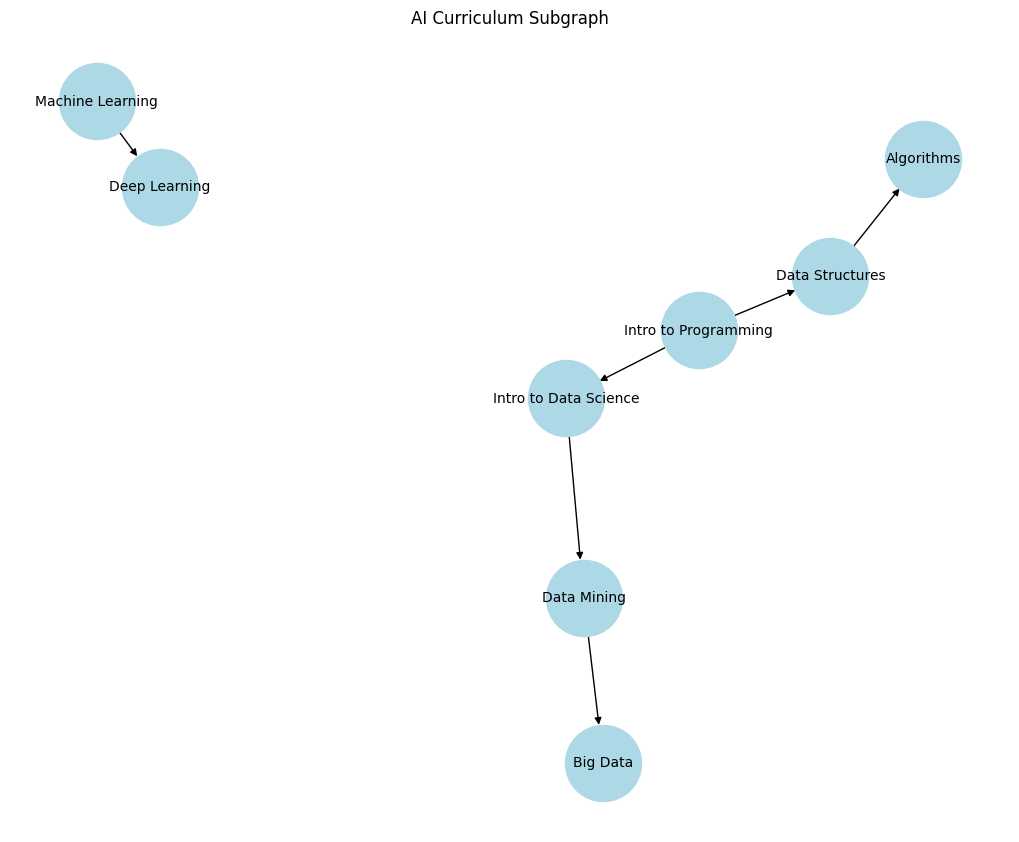

In [41]:

# Visualize a portion of the curriculum graph
plt.figure(figsize=(10, 8))
subgraph_nodes = interest_sequences["Data Science"] + ["Machine Learning", "Deep Learning"] +["Intro to Programming", "Data Structures", "Algorithms"]
subgraph = G.subgraph(subgraph_nodes)
pos = nx.spring_layout(subgraph)
nx.draw(subgraph, pos, with_labels=True, node_color="lightblue", node_size=3000, font_size=10, arrows=True)
plt.title("AI Curriculum Subgraph")
plt.show()